In [22]:
import sys
sys.path.append('../')
import helper

import numpy as np
from tqdm import tqdm
import torch

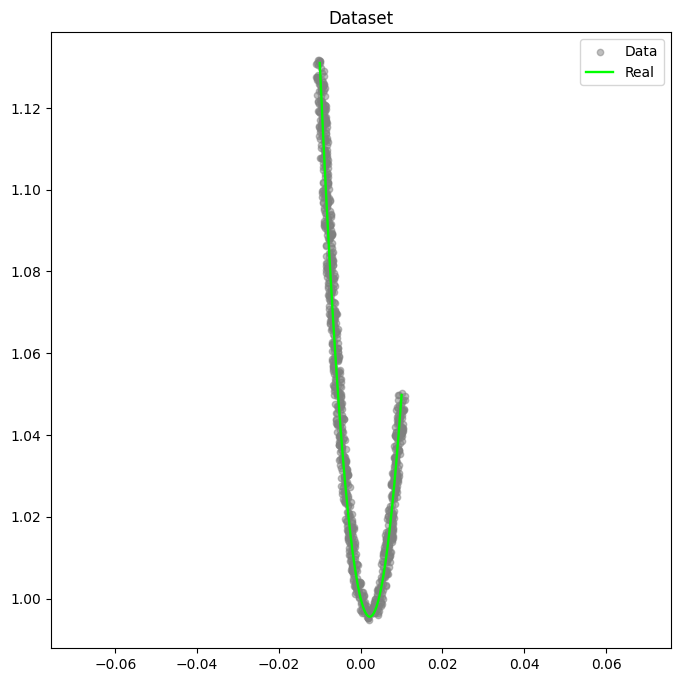

In [23]:
dataset_name = '1'
dataset_params = helper.get_params_dataset(dataset_name)
dataset_filename = helper.get_filenames_datasets()[dataset_name]
f = helper.get_func_research(dataset_params['f_label'])

X, Y, datasets = helper.load_datasets(dataset_filename)

helper.print_generated(X, Y, datasets[0], title="Dataset")

real_w = np.array([dataset_params["w0"], dataset_params["w1"]], dtype=float)

x_train_numpy_all = [dataset[:, :-1] for dataset in datasets]
y_train_numpy_all = [dataset[:, -1:] for dataset in datasets]
x_train_torch_all = [torch.from_numpy(x_train_numpy_all[i]) for i in range(dataset_params["test_count"])]
y_train_torch_all = [torch.from_numpy(y_train_numpy_all[i]) for i in range(dataset_params["test_count"])]

initial_w = np.array([-1.0, 0.1])

eps_minimum_all = [helper.mse_loss_torch(x_train_torch_all[i], torch.from_numpy(y_train_numpy_all[i]), torch.from_numpy(real_w), f)*1.1 for i in range(dataset_params["test_count"])]
eps_mean_init_w = sum([helper.mse_loss_torch(x_train_torch_all[i], torch.from_numpy(y_train_numpy_all[i]), torch.from_numpy(initial_w), f) for i in range(dataset_params["test_count"])]) / dataset_params["test_count"]

In [24]:
def get_average_loss_history(multi_points):
    k = 0.0

    max_len = 0 
    for points in multi_points:
        max_len = max(max_len, len(points))

    result = []

    for j in tqdm(range(max_len), desc="Get mse loss history"):
        mean = 0.0
        k = 0
        for i in range(len(multi_points)):
            if len(multi_points[i]) > j:
                mean += helper.mse_loss(f, multi_points[i][j], x_train_numpy_all[i], y_train_numpy_all[i])
                k += 1
        result.append(mean / k)

    return result

In [25]:
from operator import itemgetter

def subdict(d, ks):
    return dict(zip(ks, itemgetter(*ks)(d)))

In [26]:
import matplotlib.pyplot as plt

def print_mse_loss_history(results_dict, x_max=None):
    for key, value in results_dict.items():
        plt.plot(value, label=key)

    if x_max is not None:
        plt.ylim(0, x_max)

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [27]:
results_dict = {}

In [28]:
label = "torch.optim.SGD"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i], initial_w, helper.mse_loss_torch, torch.optim.SGD, lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 551/551 [00:00<00:00, 920.00it/s]


In [29]:
label = "torch.optim.SGD with momentum"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i], initial_w, helper.mse_loss_torch, torch.optim.SGD, lr=10, momentum=0.9))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 97/97 [00:00<00:00, 795.40it/s]


In [30]:
label = "torch.optim.SGD with Nesterov momentum"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i], initial_w, helper.mse_loss_torch, torch.optim.SGD, lr=10, momentum=0.9, nesterov=True))

results_dict[label] = get_average_loss_history(multi_points)

Testing method torch.optim.SGD with Nesterov momentum: 100%|██████████| 100/100 [00:01<00:00, 58.97it/s]
Get mse loss history: 100%|██████████| 93/93 [00:00<00:00, 795.57it/s]


In [31]:
label = "torch.optim.Adagrad"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i],initial_w, helper.mse_loss_torch, torch.optim.Adagrad, lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 68/68 [00:00<00:00, 806.61it/s]


In [32]:
label = "torch.optim.RMSprop"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i],initial_w, helper.mse_loss_torch, torch.optim.RMSprop, lr=1))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 60/60 [00:00<00:00, 804.66it/s]


In [33]:
label = "torch.optim.Adam"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i],initial_w, helper.mse_loss_torch, torch.optim.Adam, lr=5))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 73/73 [00:00<00:00, 1185.15it/s]


In [34]:
label = "SGD"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_sgd(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 550/550 [00:00<00:00, 977.89it/s]


In [35]:
label = "Momentum"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_momentum(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 100/100 [00:00<00:00, 843.11it/s]


In [36]:
label = "Nesterov"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_nesterov(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 95/95 [00:00<00:00, 814.51it/s]


In [37]:
label = "AdaGrad"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_ada_grad(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 1390/1390 [00:00<00:00, 3250.07it/s]


In [38]:
label = "RMSProp"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_rms_prop(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=0.1))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 49/49 [00:00<00:00, 845.01it/s]


In [43]:
label = "Adam"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_adam(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=0.5))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 54/54 [00:00<00:00, 815.37it/s]


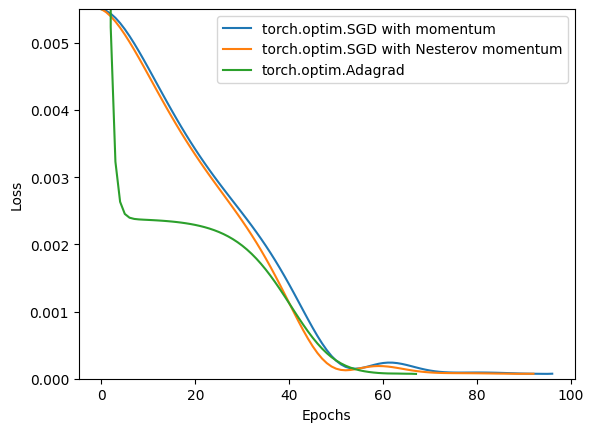

In [40]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.SGD with momentum", "torch.optim.SGD with Nesterov momentum", "torch.optim.Adagrad"]), eps_mean_init_w)

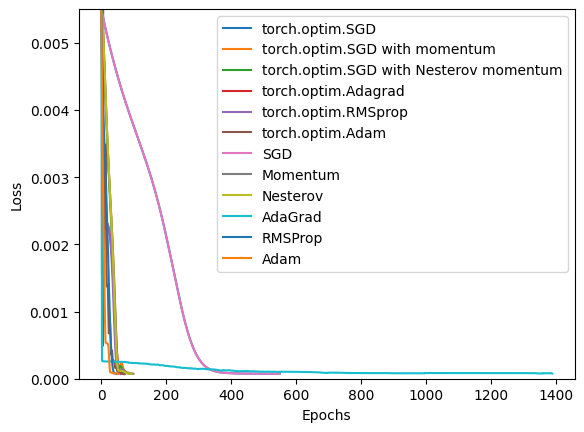

In [44]:
print_mse_loss_history(results_dict, eps_mean_init_w)

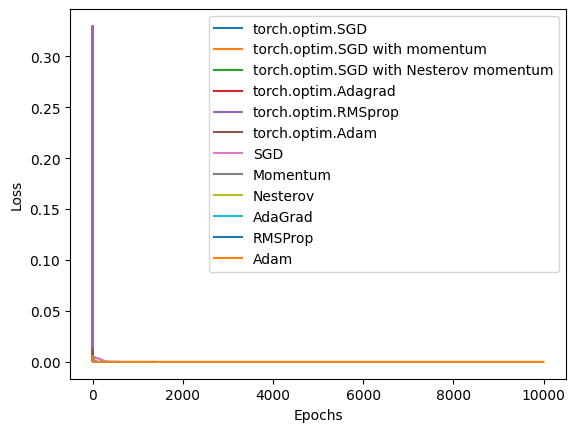

In [42]:
print_mse_loss_history(results_dict)